In [ ]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-2a003y2x
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-2a003y2x
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit d2b0d88a71e8058646d41c2eb0eb29d70e258997
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-d2i5h4tv/elegantrl_f1ce4bd1afcf4a6092d0a66626c7ac96
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-d2i5h4tv/elegantrl_f1ce4bd1afcf4a6092d0a66626c7ac96
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 155f07fcfe2d0f0a0318f820e8e2f2401ff30eca
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install --upgrade tensorflow

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

%matplotlib inline
from finrl.config import INDICATORS

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Backtesting

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/FinRL/train_data.csv')
trade = pd.read_csv('/content/drive/MyDrive/FinRL/trade_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [ ]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
trained_a2c = A2C.load('/content/drive/MyDrive/FinRL/agent_a2c.zip') if if_using_a2c else None
trained_ddpg = DDPG.load("/content/drive/MyDrive/FinRL/agent_ddpg.zip") if if_using_ddpg else None
trained_ppo = PPO.load("/content/drive/MyDrive/FinRL/agent_ppo.zip") if if_using_ppo else None
trained_td3 = TD3.load("/content/drive/MyDrive/FinRL/agent_td3.zip") if if_using_td3 else None
trained_sac = SAC.load("/content/drive/MyDrive/FinRL/agent_sac.zip") if if_using_sac else None

## Out-of-Sample Performance

In [ ]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 8, State Space: 81


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym) if if_using_a2c else (None, None)

df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym) if if_using_ddpg else (None, None)

df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym) if if_using_ppo else (None, None)

df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment = e_trade_gym) if if_using_td3 else (None, None)

df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment = e_trade_gym) if if_using_sac else (None, None)

hit end!
hit end!
hit end!
hit end!
hit end!


# Mean Variance Optimization

MVO will be the baseline to compare our agent performance

In [ ]:
# Helps us process data into a form for weight calculation
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

# Calculates weights of average return and covariance matrix
def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

array([[135.14633179, 171.64849854, 203.55599976, ...,  51.79020691,
        265.22750854,  17.66327858],
       [137.79473877, 175.54899597, 204.54225159, ...,  52.48370361,
        271.13555908,  17.73609161],
       [139.82284546, 183.78700256, 200.55963135, ...,  51.86418533,
        271.14538574,  17.60866737],
       ...,
       [192.17477417, 159.11999512, 298.34246826, ...,  43.52243042,
        403.18441772,  17.01135635],
       [191.48565674, 161.25999451, 302.14859009, ...,  43.7118721 ,
        408.9637146 ,  16.97200012],
       [187.800354  , 159.        , 303.65310669, ...,  42.79455948,
        407.83581543,  17.24748802]])

In [ ]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.14  0.154 0.08  0.104 0.039 0.071 0.105 0.037]
Variance-Covariance matrix of returns
 [[3.276 1.695 1.575 1.28  1.14  1.663 1.634 0.795]
 [1.695 4.475 1.484 1.26  1.063 1.497 1.855 0.678]
 [1.575 1.484 3.957 1.479 1.491 1.832 1.564 1.155]
 [1.28  1.26  1.479 2.316 1.107 1.426 1.328 0.891]
 [1.14  1.063 1.491 1.107 2.087 1.391 1.219 0.932]
 [1.663 1.497 1.832 1.426 1.391 3.452 1.858 0.991]
 [1.634 1.855 1.564 1.328 1.219 1.858 2.763 0.836]
 [0.795 0.678 1.155 0.891 0.932 0.991 0.836 1.565]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Calculate the efficient Frontier to get weights

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(8)])

mvo_weights

array([407980., 325500.,      0., 266530.,      0.,      0.,      0.,
            0.])

### Apply the weights to the last price of our stock data

In [ ]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)

Initial_Portfolio

array([3025.634, 1892.354,    0.   ,  894.131,    0.   ,    0.   ,
          0.   ,    0.   ])

### Test our MVO weights on the out-of-sample data

In [ ]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])

MVO_result

,Mean Var
2021-07-01,1.002468e+06
2021-07-02,1.018832e+06
2021-07-06,1.037682e+06
2021-07-07,1.050777e+06
2021-07-08,1.045982e+06
...,...
2024-01-24,1.193248e+06
2024-01-25,1.197205e+06
2024-01-26,1.198358e+06
2024-01-29,1.200678e+06


# DOW JONES Index as Another Baseline

In [ ]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2021-07-01'
TRADE_START_DATE = '2021-07-01'
TRADE_END_DATE = '2024-02-01'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['^dji']).fetch_data()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (650, 8)


In [ ]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None

result = pd.DataFrame()
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Merge DataFrames and view Results

In [ ]:
col_name = []
col_name.append('A2C') if if_using_a2c else None
result.columns = col_name

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

<ipython-input-23-9cfe681e3b58>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')


In [ ]:
result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,A2C,Mean Var,close
date,,,
2021-07-01,1.000000e+06,1.002468e+06,1.000000e+06
2021-07-02,9.996285e+05,1.018832e+06,1.004412e+06
2021-07-06,9.978566e+05,1.037682e+06,9.983784e+05
2021-07-07,9.994133e+05,1.050777e+06,1.001393e+06
2021-07-08,9.968152e+05,1.045982e+06,9.938903e+05
...,...,...,...
2024-01-25,1.482792e+06,1.197205e+06,1.098621e+06
2024-01-26,1.437630e+06,1.198358e+06,1.100362e+06
2024-01-29,1.443546e+06,1.200678e+06,1.106831e+06


In [ ]:
result_filtered = result.loc[:'2024-01-30']  # Filter data up to 2024-01-30
result_filtered

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,A2C,Mean Var,close
date,,,
2021-07-01,1.000000e+06,1.002468e+06,1.000000e+06
2021-07-02,9.996285e+05,1.018832e+06,1.004412e+06
2021-07-06,9.978566e+05,1.037682e+06,9.983784e+05
2021-07-07,9.994133e+05,1.050777e+06,1.001393e+06
2021-07-08,9.968152e+05,1.045982e+06,9.938903e+05
...,...,...,...
2024-01-24,1.404928e+06,1.193248e+06,1.091612e+06
2024-01-25,1.482792e+06,1.197205e+06,1.098621e+06
2024-01-26,1.437630e+06,1.198358e+06,1.100362e+06


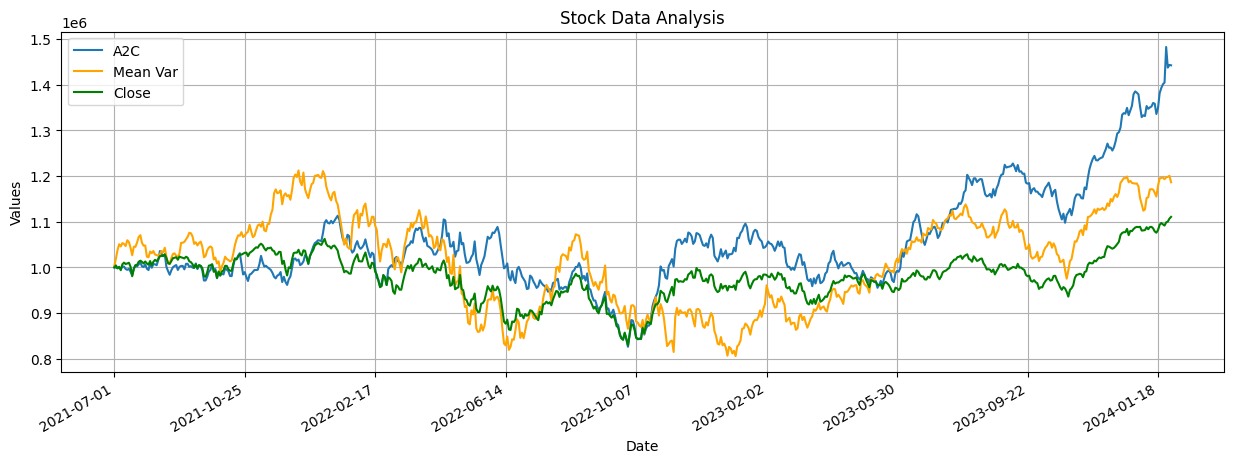

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'result' is your DataFrame and it's already loaded with 'date' as the index
result_filtered = result.loc[:'2024-01-30']  # Filter data up to 2024-01-30

plt.figure(figsize=(15, 5))
plt.plot(result_filtered.index, result_filtered['A2C'], label='A2C')
plt.plot(result_filtered.index, result_filtered['Mean Var'], label='Mean Var', color='orange')
plt.plot(result_filtered.index, result_filtered['close'], label='Close', color='green')

# Formatting the date on the x-axis to look clean
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Reduce the number of x-axis labels
plt.gcf().autofmt_xdate()  # Auto format the date labels to prevent overlap

plt.title('Stock Data Analysis')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None

result = pd.DataFrame()
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)

col_name = []
col_name.append('DDPG') if if_using_ddpg else None
result.columns = col_name

result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

result

<ipython-input-43-681cd1302d68>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')


,DDPG,Mean Var,close
date,,,
2021-07-01,1.000000e+06,1.002468e+06,1.000000e+06
2021-07-02,1.000937e+06,1.018832e+06,1.004412e+06
2021-07-06,1.002542e+06,1.037682e+06,9.983784e+05
2021-07-07,1.003474e+06,1.050777e+06,1.001393e+06
2021-07-08,1.003144e+06,1.045982e+06,9.938903e+05
...,...,...,...
2024-01-25,1.233817e+06,1.197205e+06,1.098621e+06
2024-01-26,1.234746e+06,1.198358e+06,1.100362e+06
2024-01-29,1.252136e+06,1.200678e+06,1.106831e+06


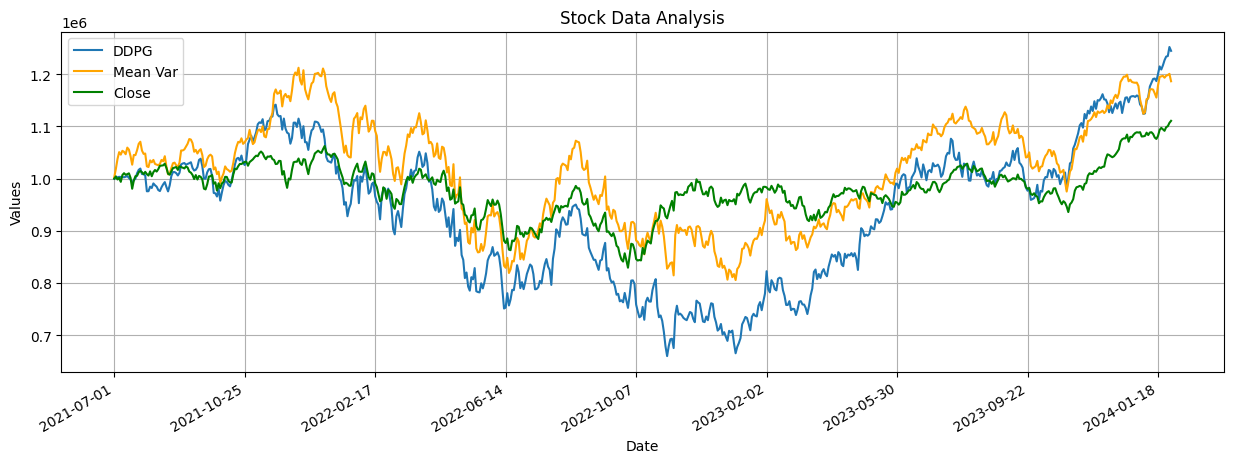

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'result' is your DataFrame and it's already loaded with 'date' as the index
result_filtered = result.loc[:'2024-01-30']  # Filter data up to 2024-01-30

plt.figure(figsize=(15, 5))
plt.plot(result_filtered.index, result_filtered['DDPG'], label='DDPG')
plt.plot(result_filtered.index, result_filtered['Mean Var'], label='Mean Var', color='orange')
plt.plot(result_filtered.index, result_filtered['close'], label='Close', color='green')

# Formatting the date on the x-axis to look clean
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Reduce the number of x-axis labels
plt.gcf().autofmt_xdate()  # Auto format the date labels to prevent overlap

plt.title('Stock Data Analysis')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None

result = pd.DataFrame()
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)

col_name = []
col_name.append('PPO') if if_using_ppo else None
result.columns = col_name

result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

result

<ipython-input-45-b262ae25ce6f>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')


,PPO,Mean Var,close
date,,,
2021-07-01,1.000000e+06,1.002468e+06,1.000000e+06
2021-07-02,1.000493e+06,1.018832e+06,1.004412e+06
2021-07-06,1.000772e+06,1.037682e+06,9.983784e+05
2021-07-07,1.001845e+06,1.050777e+06,1.001393e+06
2021-07-08,1.000718e+06,1.045982e+06,9.938903e+05
...,...,...,...
2024-01-25,1.449842e+06,1.197205e+06,1.098621e+06
2024-01-26,1.443374e+06,1.198358e+06,1.100362e+06
2024-01-29,1.460665e+06,1.200678e+06,1.106831e+06


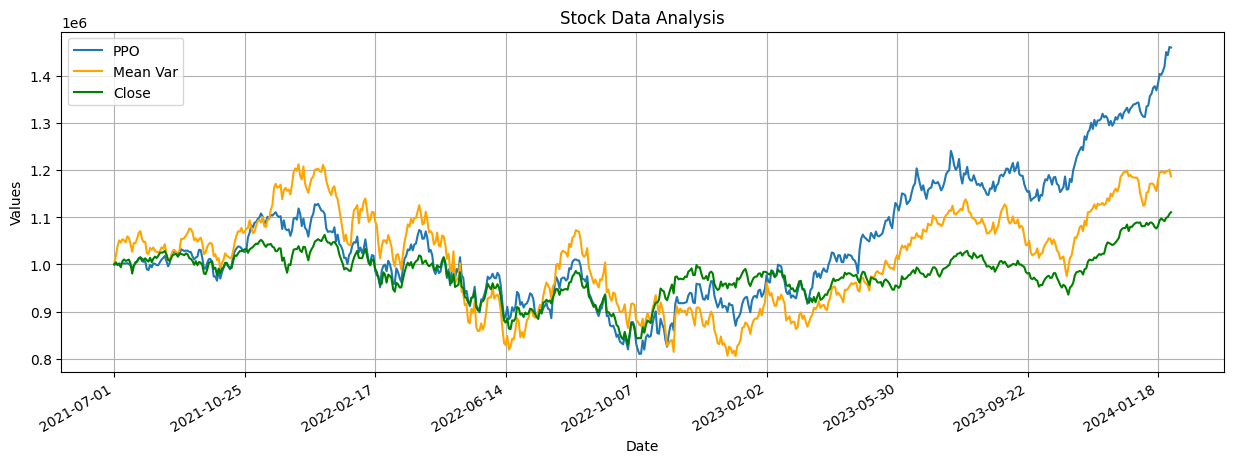

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'result' is your DataFrame and it's already loaded with 'date' as the index
result_filtered = result.loc[:'2024-01-30']  # Filter data up to 2024-01-30

plt.figure(figsize=(15, 5))
plt.plot(result_filtered.index, result_filtered['PPO'], label='PPO')
plt.plot(result_filtered.index, result_filtered['Mean Var'], label='Mean Var', color='orange')
plt.plot(result_filtered.index, result_filtered['close'], label='Close', color='green')

# Formatting the date on the x-axis to look clean
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Reduce the number of x-axis labels
plt.gcf().autofmt_xdate()  # Auto format the date labels to prevent overlap

plt.title('Stock Data Analysis')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None

result = pd.DataFrame()
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)

col_name = []
col_name.append('TD3') if if_using_td3 else None
result.columns = col_name

result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

result

<ipython-input-47-dc954f503298>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')


,TD3,Mean Var,close
date,,,
2021-07-01,1.000000e+06,1.002468e+06,1.000000e+06
2021-07-02,1.000702e+06,1.018832e+06,1.004412e+06
2021-07-06,1.001907e+06,1.037682e+06,9.983784e+05
2021-07-07,1.003250e+06,1.050777e+06,1.001393e+06
2021-07-08,1.002401e+06,1.045982e+06,9.938903e+05
...,...,...,...
2024-01-25,1.242364e+06,1.197205e+06,1.098621e+06
2024-01-26,1.239088e+06,1.198358e+06,1.100362e+06
2024-01-29,1.249137e+06,1.200678e+06,1.106831e+06


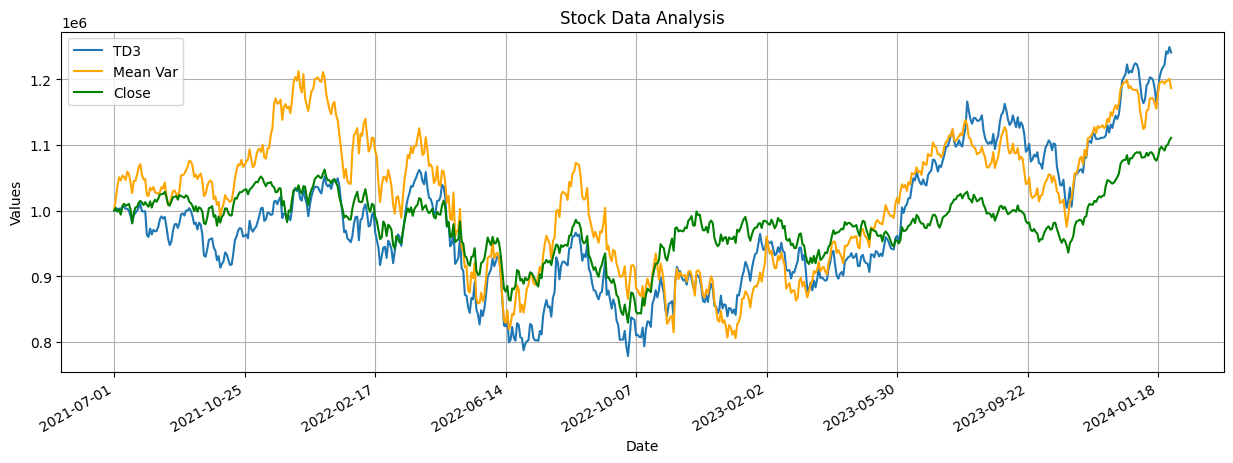

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'result' is your DataFrame and it's already loaded with 'date' as the index
result_filtered = result.loc[:'2024-01-30']  # Filter data up to 2024-01-30

plt.figure(figsize=(15, 5))
plt.plot(result_filtered.index, result_filtered['TD3'], label='TD3')
plt.plot(result_filtered.index, result_filtered['Mean Var'], label='Mean Var', color='orange')
plt.plot(result_filtered.index, result_filtered['close'], label='Close', color='green')

# Formatting the date on the x-axis to look clean
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Reduce the number of x-axis labels
plt.gcf().autofmt_xdate()  # Auto format the date labels to prevent overlap

plt.title('Stock Data Analysis')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None

result = pd.DataFrame()
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)

col_name = []
col_name.append('SAC') if if_using_sac else None
result.columns = col_name

result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

result

<ipython-input-49-e459cd0527c8>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')


,SAC,Mean Var,close
date,,,
2021-07-01,1.000000e+06,1.002468e+06,1.000000e+06
2021-07-02,1.000128e+06,1.018832e+06,1.004412e+06
2021-07-06,9.990532e+05,1.037682e+06,9.983784e+05
2021-07-07,1.001035e+06,1.050777e+06,1.001393e+06
2021-07-08,9.982142e+05,1.045982e+06,9.938903e+05
...,...,...,...
2024-01-25,1.327116e+06,1.197205e+06,1.098621e+06
2024-01-26,1.320084e+06,1.198358e+06,1.100362e+06
2024-01-29,1.328158e+06,1.200678e+06,1.106831e+06


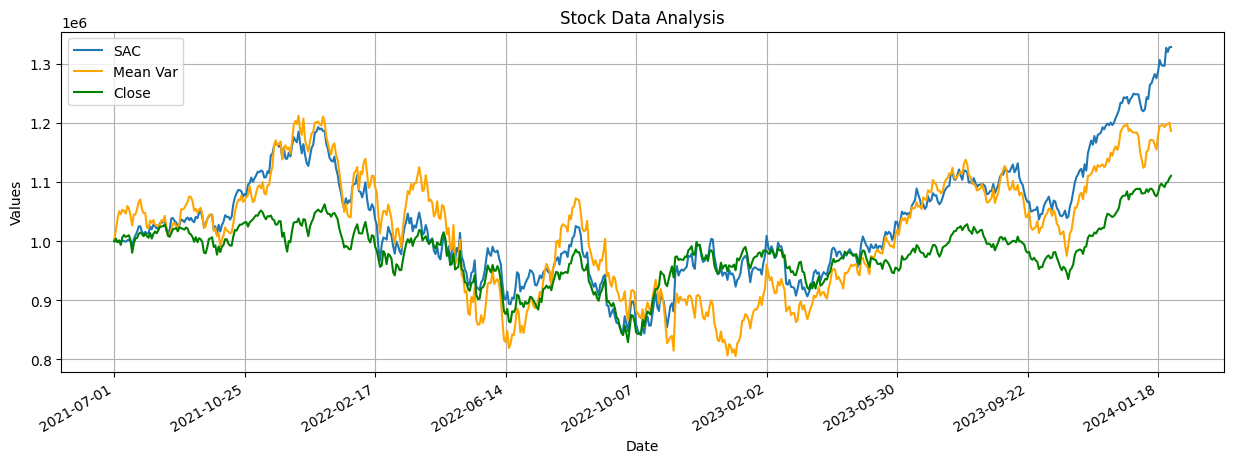

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'result' is your DataFrame and it's already loaded with 'date' as the index
result_filtered = result.loc[:'2024-01-30']  # Filter data up to 2024-01-30

plt.figure(figsize=(15, 5))
plt.plot(result_filtered.index, result_filtered['SAC'], label='SAC')
plt.plot(result_filtered.index, result_filtered['Mean Var'], label='Mean Var', color='orange')
plt.plot(result_filtered.index, result_filtered['close'], label='Close', color='green')

# Formatting the date on the x-axis to look clean
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Reduce the number of x-axis labels
plt.gcf().autofmt_xdate()  # Auto format the date labels to prevent overlap

plt.title('Stock Data Analysis')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()